## Spaceship Titanic Competition

This is my entry for the spaceship titanic competition, the task is to predict if a passanger was transported to an alternate dimension after the ship's collision with a spacetime anomaly

Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score

### Data dictionary

- **PassengerId** - A unique Id for each passenger. Each Id takes the form ```gggg_pp``` where ```gggg``` indicates a group the passenger is travelling with and ```pp``` is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** - The planet the passenger will be debarking to.
- **Age** - The age of the passenger.
- **VIP** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name** - The first and last names of the passenger.
- **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [2]:
# List all the files
for dirpath, dirnames, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

../data/sample_submission.csv
../data/test.csv
../data/train.csv


In [3]:
# Another way 
os.listdir('../data/')

['sample_submission.csv', 'test.csv', 'train.csv']

let's load the data

In [4]:
df = pd.read_csv('../data/train.csv')

## EDA - Exploratory Data Analisis

Check the data 


In [5]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [8]:
df.describe()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [9]:
print(df.shape)

(8693, 14)


Check for null values in the dataframe 

In [10]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Check how many people were transported into another dimension

In [11]:
df['Transported'].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

Check correlation between features 

In [12]:
df.corr(numeric_only=True)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


In [13]:
df['CryoSleep'].value_counts()

CryoSleep
False    5439
True     3037
Name: count, dtype: int64

How many people that were in cryosleep got transported? 

In [14]:
df_grouped_cryo = df['CryoSleep'].loc[df['Transported'] == 1].value_counts()
df_grouped_cryo

CryoSleep
True     2483
False    1789
Name: count, dtype: int64

Let's see this as a graph

Text(0.5, 1.0, 'Passengers grouped by cryo sleep that got transported')

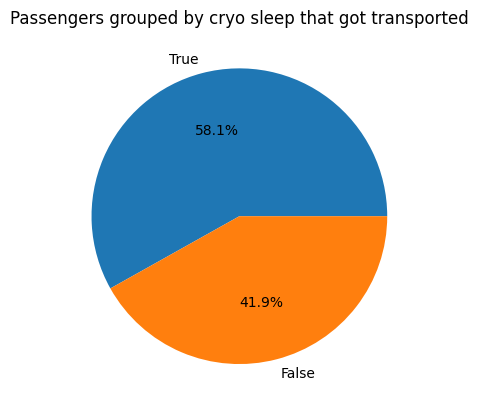

In [15]:
fig, ax = plt.subplots(1, 1)
ax.pie(df_grouped_cryo, labels=['True', 'False'], autopct='%1.1f%%')
ax.set_title('Passengers grouped by cryo sleep that got transported')

Text(0.5, 1.0, 'Passengers grouped by cryo sleep that got transported')

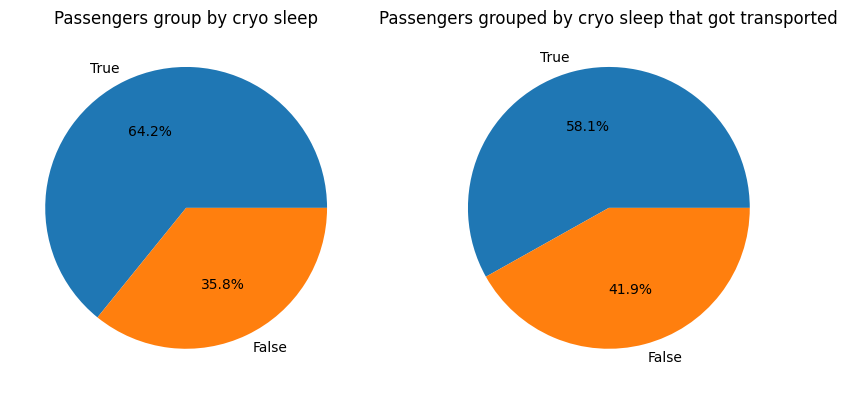

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].pie(df.groupby('CryoSleep').count()['PassengerId'], labels=df_grouped_cryo.index, autopct='%.1f%%')
ax[0].set_title('Passengers group by cryo sleep')
ax[1].pie(df_grouped_cryo, labels=df_grouped_cryo.index, autopct='%.1f%%')
ax[1].set_title('Passengers grouped by cryo sleep that got transported')

Let's do the same but grouping by home planet

In [17]:
# Here i'm using another way of filtering and goruping
df_grouped_home = df.loc[df['Transported'] == 1].groupby('HomePlanet').count()['PassengerId']
df_grouped_home

HomePlanet
Earth     1951
Europa    1404
Mars       920
Name: PassengerId, dtype: int64

Text(0.5, 1.0, 'Passengers grouped by home planet who got transported')

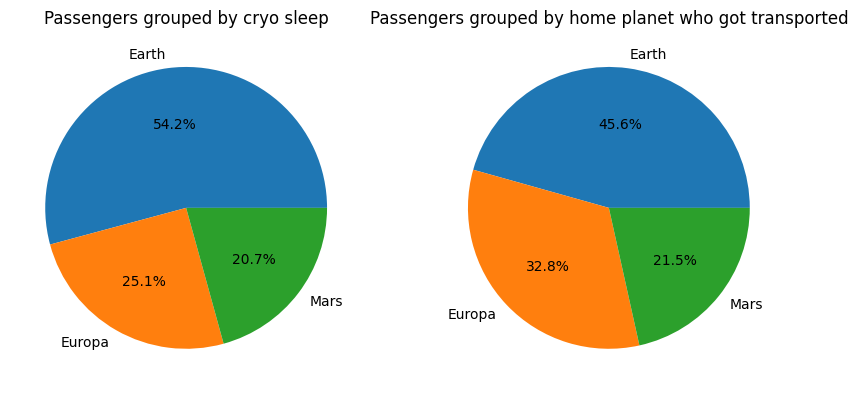

In [18]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))
ax[0].pie(df.groupby('HomePlanet').count()['PassengerId'], labels=df_grouped_home.index, autopct='%.1f%%')
ax[0].set_title('Passengers grouped by cryo sleep')
ax[1].pie(df_grouped_home, labels=df_grouped_home.index, autopct='%.1f%%')
ax[1].set_title('Passengers grouped by home planet who got transported')

In [19]:
df['Destination'].value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [20]:
df['Destination'].loc[df['Transported'] == True ].value_counts()

Destination
TRAPPIST-1e      2787
55 Cancri e      1098
PSO J318.5-22     401
Name: count, dtype: int64

Text(0.5, 1.0, 'Passengers grouped by destination who got transported')

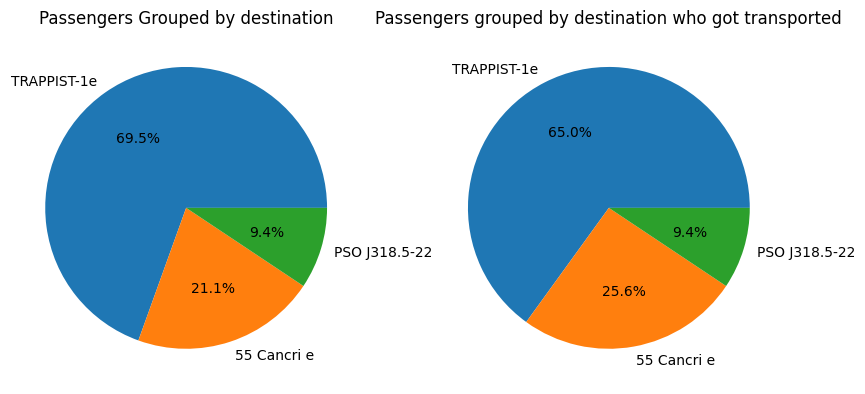

In [21]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))
ax[0].pie(df['Destination'].value_counts(), labels=df['Destination'].value_counts().index,
                                                    autopct='%.1f%%')
ax[0].set_title('Passengers Grouped by destination')
ax[1].pie(df['Destination'].loc[df['Transported'] == True ].value_counts(),
                        labels=df['Destination'].value_counts().index, autopct='%1.1f%%',)
ax[1].set_title('Passengers grouped by destination who got transported')

In [22]:
df['Cabin'].value_counts()

Cabin
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: count, Length: 6560, dtype: int64

Splitting the Cabin in order to get *deck* / *num* / *side*

In [23]:
# Using python's list split method
str(df['Cabin'][0]).split('/')

['B', '0', 'P']

In [24]:
# Using Pandas's string Series split method
df['Cabin'].str.split('/', expand=True)

,0,1,2
0,B,0,P
1,F,0,S
2,A,0,S
3,A,0,S
4,F,1,S
...,...,...,...
8688,A,98,P
8689,G,1499,S
8690,G,1500,S
8691,E,608,S


In [45]:
df['Age'].describe()

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

fig, ax = plt.subplots(1, 2, figsize= (10, 5))
ax[0].pie(df.groupby(

[ 0 10 20 30 40 50 60 70 80]


(array([ 483.,  788., 1296.,  796.,  531.,  275.,   99.,   20.]),
 array([ 0., 10., 20., 30., 40., 50., 60., 70., 80.]),
 <BarContainer object of 8 artists>)

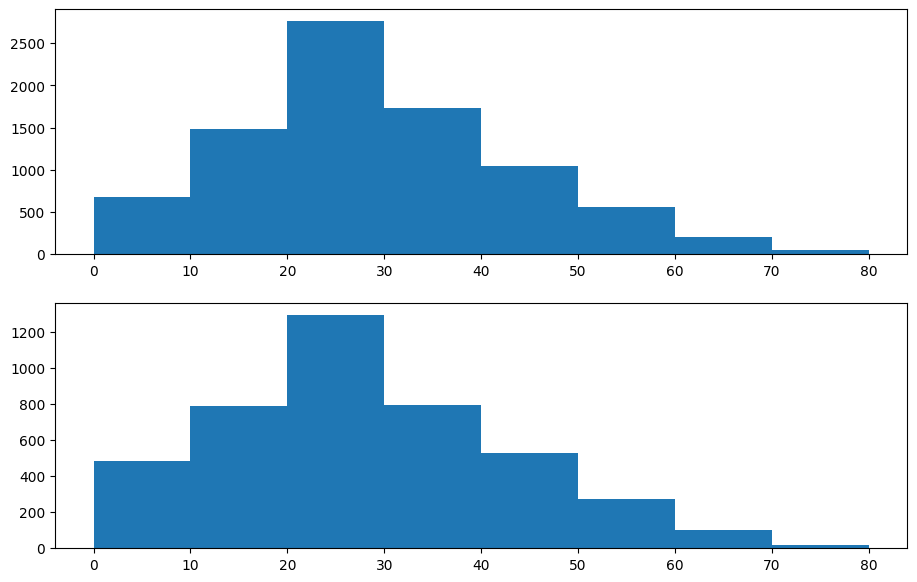

In [49]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=[11, 7])
# bins = range(0, 90, 10)
bins = np.arange(0, 90, 10)
print(bins)
ax0.hist(df['Age'], bins)
ax1.hist(df['Age'].loc[df['Transported'] == True], bins=bins )